In [1]:
#! /usr/bin/python3

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys, os, subprocess
import argparse
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='w|arn'
import seaborn as sns
from scipy.interpolate import griddata
import math
from scipy.signal import savgol_filter
from tqdm import tqdm

In [2]:
def create_grid_velocities_crust (xmin_plot:float, xmax_plot:float, ymin_plot:float, ymax_plot:float, grid_res:float, grid_low_res:float, grid_high_res: float)  :
    # create grid to interpolate stuff onto (for plotting)
    x_low = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_res))
    y_low =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_res))
    X_low, Y_low = np.meshgrid(x_low,y_low)
    # lower res grid for velocities
    x_vels = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_low_res))
    y_vels =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_low_res))
    X_vels, Y_vels = np.meshgrid(x_vels,y_vels)
    # higher res grid for crust
    x_crust = np.linspace(xmin_plot,xmax_plot,int((xmax_plot-xmin_plot)/grid_high_res))
    y_crust =  np.linspace(ymin_plot,ymax_plot,int((ymax_plot-ymin_plot)/grid_high_res))
    X_crust, Y_crust = np.meshgrid(x_crust,y_crust)
    return (X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust)


def interp_T_visc_vel_comp_tau (x, y, T, visc, v, C, t, X_low, Y_low, X_crust, Y_crust):
    Temp = griddata((x, y), T-273,    (X_low, Y_low), method='cubic')
    Visc = griddata((x, y), visc, (X_low, Y_low), method='linear') 
    V = griddata((x, y), v,   (X_crust, Y_crust), method='cubic')
    Comp = griddata((x, y), C,   (X_crust, Y_crust), method='cubic')
    tau = griddata((x, y), t,   (X_crust, Y_crust), method='cubic')
    return (Temp, Visc,V, Comp, tau)






def get_points_with_y_in(data, depth, delta, ymax = 2900.e3): 
    plate_prof_loc = ymax - depth
    within_delta_from_depth = (data['Points:1'] < plate_prof_loc + delta) &(data['Points:1'] > plate_prof_loc - delta)
    return data[within_delta_from_depth].sort_values('Points:0').copy(True)



def get_crust(contour):    
    conts = len(contour.collections[0].get_paths())
    j = 0
    for i in range(conts):
        if len(contour.collections[0].get_paths()[j]) < len(contour.collections[0].get_paths()[i]):
            j = i
    pts = contour.collections[0].get_paths()[j].vertices
    return pts


def get_trench_position(p, threshold = 0.3e7):
    if "oc" in p.columns:
        tr =  p.loc[(p['Points:0']> threshold) & (p['oc'] > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    elif {"oc","sed"}.issubset(p.columns):
        sumcomp = p["oc"] + p["sed"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    else:
        sumcomp = p["oc"] + p["serp"]
        tr =  p.loc[(p['Points:0']> threshold) & (sumcomp > 0.3) & (p["Points:1"] >= p["Points:1"].max() - 10.e3),'Points:0'].max()
    return tr


def get_slab_top(slab):
    # threshold_x = (slab[slab[:,1] > 10.]).min(0)[0]
    # slab_tot = slab[slab[:,0]> threshold_x]
    tip = slab[:,0].argmax()
    slab_top = slab[tip:, :][::-1, :]
    return slab_top

In [3]:
csvs_loc =  '/home/vturino/PhD/projects/exhumation/gz_outputs/'
models_loc =  '/home/vturino/PhD/projects/exhumation/raw_outputs/'
json_loc = '/home/vturino/PhD/projects/exhumation/pyInput/'

json_file = f"dyn_geom.json"
with open(f"{json_loc}{json_file}") as json_file:
        configs = json.load(json_file)

mod = configs["models"][0]

In [4]:
xmin_plot = 0.e3
xmax_plot = 5400.e3
ymin_plot = 0.e3
ymax_plot = 900.e3
grid_res=5.e3; grid_low_res = 20.e3; grid_high_res = 0.5e3
X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust = create_grid_velocities_crust (xmin_plot, xmax_plot, ymin_plot, ymax_plot, grid_res, grid_low_res, grid_high_res)


In [5]:
data = pd.read_parquet(f"{csvs_loc}{mod}/fields/full.{int(5)}.gzip")
pts = get_points_with_y_in(data, 20.e3, 2.e3, ymax = 900.e3)
trench= get_trench_position(pts,threshold = 0.13e7)
data["comp"] = data.loc[:,'oc'] + data.loc[:,'sed']
data["vel"] = (data["velocity:0"]**2 + data["velocity:1"]**2)**(1/2)

xmin_plot = trench - 100.e3
xmax_plot = trench + 200.e3
ymin_plot = 700.e3
ymax_plot = 900.e3
grid_res=5.e3; grid_low_res = 20.e3; grid_high_res = 0.5e3
X_low, Y_low, X_vels, Y_vels, X_crust, Y_crust = create_grid_velocities_crust (xmin_plot, xmax_plot, ymin_plot, ymax_plot, grid_res, grid_low_res, grid_high_res)


/tmp/ipykernel_1698546/1527210468.py:8: RuntimeWarning: invalid value encountered in log10
  t_plot = plt.contourf(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, np.log10(tau),cmap=matplotlib.colormaps.get_cmap('RdBu_r'),levels=np.linspace(1, 9,301),extend='both')


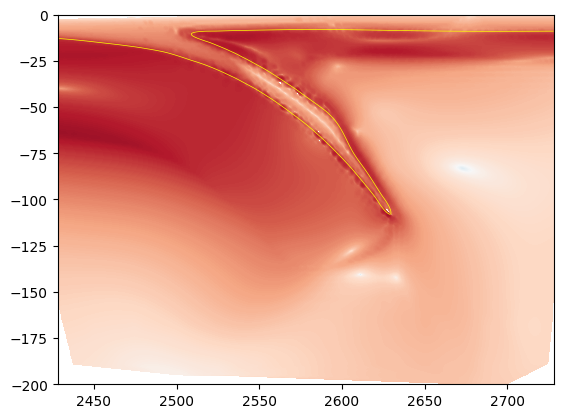

In [11]:
fil = (data["Points:0"] >= xmin_plot) & (data["Points:0"] <= xmax_plot ) & (data["Points:1"] >= ymin_plot)

points = data[fil]
interface = points[points["comp"]>0].sort_values(by="Points:0")
points["shear_stress"] = np.sqrt(points["shear_stress:0"]**2 + points["shear_stress:1"]**2 + points["shear_stress:3"]**2 + points["shear_stress:4"]**2)

T, visc, vel, comp, tau = interp_T_visc_vel_comp_tau(points.loc[:,'Points:0'], points.loc[:,'Points:1'], points.loc[:,'T'], points.loc[:,'viscosity'], points.loc[:,'vel'], points.loc[:,'comp'], points.loc[:,"shear_stress"], X_low, Y_low, X_crust, Y_crust)  
t_plot = plt.contourf(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, np.log10(tau),cmap=matplotlib.colormaps.get_cmap('RdBu_r'),levels=np.linspace(1, 9,301),extend='both')
crust_cont = plt.contour(X_crust/1.e3, -(ymax_plot-Y_crust)/1.e3, comp, levels=[0.3], linewidths=0.5, colors='yellow', zorder=2, alpha = 1)
crust_vec = get_crust(crust_cont)
(crust_vec[:,0], crust_vec[:,1]) = savgol_filter((crust_vec[:,0], crust_vec[:,1]), 71,3)
# crust_vec[:,1] = crust_vec[:,1] + 50
# plt.plot(crust_vec[:,0], crust_vec[:,1], "y")


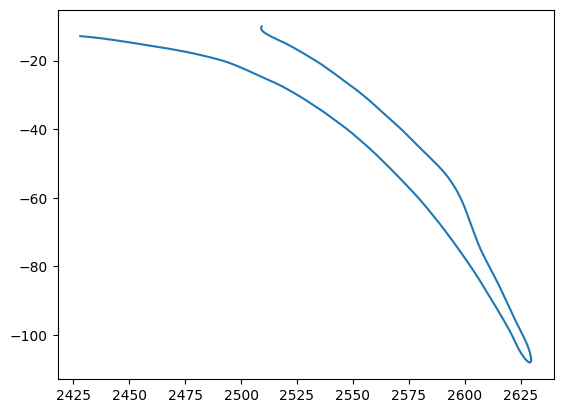

In [13]:
for i in range(1, len(crust_vec)):
    if crust_vec[i, 1] >= -10: # and crust_vec[i, 1] > crust_vec[i-1, 1]:
        crust_vec[i, 1] = np.nan
        crust_vec[i, 0] = np.nan

plt.plot(crust_vec[:,0], crust_vec[:,1])

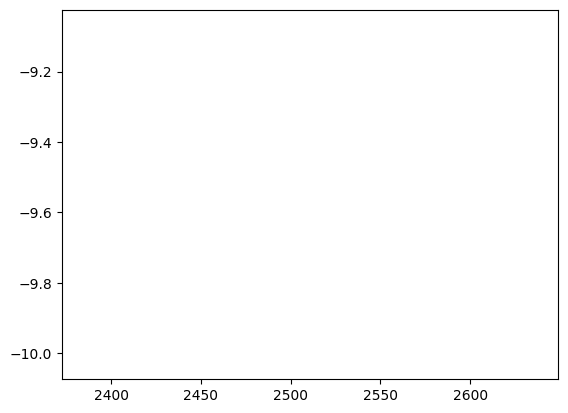

In [8]:
crust=crust_vec[~np.isnan(crust_vec[:,0])]

k = 0

for i in range(1, len(crust)):
    grad = (crust[i,1] - crust[i-1,1])/(crust[i,0] - crust[i-1,0])
    if grad >=0 and crust[i, 1] >=-100:
        k = i
        # break;

crust[:k,:] = np.nan
crust=crust[~np.isnan(crust[:,0])]
plt.plot(crust[:,0], crust[:,1])

ctop = get_slab_top(crust)
plt.plot(ctop[:,0], ctop[:,1])

In [9]:
tau_s = griddata((points.loc[:,'Points:0']/1.e3, -(ymax_plot - points.loc[:,'Points:1'])/1.e3), points.loc[:,"shear_stress"], (ctop[:,0], ctop[:,1]), method="cubic")

In [10]:
# Ts = griddata((points.loc[:,'Points:0']/1.e3, -(ymax_plot - points.loc[:,'Points:1'])/1.e3), points.loc[:,"T"], (ctop[:,0], ctop[:,1]), method="cubic")

In [83]:
# for i in range(len(Ts)):
#     if ctop[i,1] <-60:
#         print(i)
#         break;

In [84]:
# Ts[246:] = np.nan
# plt.plot(Ts, ctop[:,1])

In [85]:

# Ts = Ts[~np.isnan(Ts)]

In [86]:
# Ts.mean()

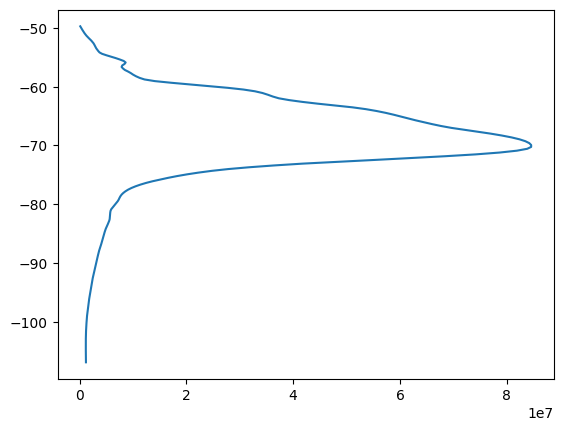

In [87]:
plt.plot(tau_s, ctop[:,1])

In [88]:
tau_s = tau_s[~np.isnan(tau_s)]
tau_s.mean()/1.e6

16.802457265181964